<div style="font-family:verdana;font-size:3.5rem;text-align:center;">
    Multi-label Rsearch Articles Classification <br /> Using Graph Neural Networks
</div>

<h1 style="font-family:verdana;" > Overview </h1>

- [Introduction](#intro)
- [Necessary Packages](#necessary_packages)
- [Constants](#constants)
- [Reproducibility](#reproducibility)
- [Preliminaries](#preliminaries)
- [Explanatory Data Analysis (EDA)](#eda)
    - [Load The Data](#load_data)
    - [Columns Description](#columns_desc)
    - [Check For Missing Values / Duplicates](#missing_dup)
    - [Visualizations](#vis)
- [Graph Construction](#graph_construction)
    - [Feature Extraction](#feature_extraction)
    - [Relations Engineering](#relations_engineering)
    - [Convert To PyG Format](#pyg)
- [Data Splitting](#data_splitting)
- [Modeling & Training](#modeling_training)
    - [Utils](#utils)
    - [Multi-Layer Perceptron](#mlp)
    - [Graph Neural Networks](#gnn)
    - [Side By Side Comparision : MLP Vs GNN](#mlp_vs_gnn)
- [Conclusion](#conclusion)

<div id="intro" >
    <h1 style="font-family:verdana;" > Introduction </h1>
</div>


In this notebook we will go through how to classify research articles uding **Graph Neural Networks** in a multi-label setting where each article <br/> belongs to one or more category, for this the [Research Articles Dataset](#https://www.kaggle.com/datasets/fellahabdelnour13/articles-classification-dataset) will be utilized.

<div id="necessary_packages" >
    <h1 style="font-family:verdana;" > Necessary Packages </h1>
</div>

In [1]:
import torch

In [2]:
VERSION = torch.__version__
print(VERSION) # For Reference Mine Was : 2.6.0+cu124

2.6.0+cu124


In [3]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 118.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.2 MB/s eta 0:00:00


In [4]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.2 MB/s eta 0:00:00


In [5]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.6/486.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 37.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [6]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import json
import seaborn as sns
import torch
import random
from torch import nn, Tensor, optim
import matplotlib.pyplot as plt
from torch import Tensor
from torch.nn import functional as F
from torch_sparse import matmul, SparseTensor
from IPython.display import display, Markdown
from functools import reduce
from wordcloud import WordCloud
from typing import Callable, Optional
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from torch_geometric import utils as gnn_utils
from torch_geometric.data import Data
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, hamming_loss
from sklearn.model_selection import train_test_split
from torch_geometric import nn as gnn
from torchinfo import summary
from torch_geometric.loader import NeighborLoader
from plotly.subplots import make_subplots
from IPython.display import HTML

2025-10-22 09:31:03.077658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761125463.267929      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761125463.330737      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
sns.set_theme(style="darkgrid", palette="husl")

<div id="constants" >
    <h1 style="font-family:verdana;" > Constants </h1>
</div>

In [8]:
DATA_DIR = "/kaggle/input/articles-classification-dataset"
WORKING_DIR = "/kaggle/working/"
DATA_PATH = os.path.join(DATA_DIR, "data.raw.json")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

<div id="reproducibility" >
    <h1 style="font-family:verdana;" > Reproducibility </h1>
</div>

In [9]:
def seed_everything(seed: int) -> None:    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [10]:
seed_everything(SEED)

<div id="preliminaries" >
    <h1 style="font-family:verdana;" > Preliminaries </h1>
</div>

<strong>Graph Neural Networks : </strong>

- Special type of neural network designed to handle graph data.

- Based on the idea of <strong>Message Passing (MLP) </strong> : Each node own's representation is updated based on its neighbors representations.

- A two step process composed of an **update** step and an **aggregation** step : 
    - **Aggregate** : compute a vector from the node's neighbors representation called a message.
    - **Update** : update the node's representation using the message.

$$
\begin{align}
h_u^{(t+1)} &= \text{UPDATE}(h_u^{(t)}, \text{AGGREGATE}(\{h_v^{(t)}, v \in \mathcal{N}(u))\}) \\
&= \text{UPDATE}(h_u^{(t)}, m_{\mathcal{N}(u)})
\end{align}
$$

<p align="center">
    <img src="https://raw.githubusercontent.com/abdelnour13/my_kaggle_notebooks/refs/heads/main/files/MP.png" alt="An illustration of the message padding mechanism">
</p>

<strong>Graph Convolutional Neural Networks (GCNs) :</strong>

Uses a simple aggregation on the node's representations but instead of uniform weights it calculates the weights based on the nodes' degrees, for comparable scales of representations of nodes of various degrees and more stable training.

$$
H^{(k+1)} = \sigma(\bar{A} \times H^{(k)} \times W^{(k)}) \text{ , } H^{(0)} = \mathcal{X}
$$

<strong>Relational Graph Convolutional Neural Networks (R-GCNs) :</strong>

**R-GCN** extends **GCNs** for multi-relational graphs, the aggregation operation considers each relation separately. 

$$
h^{(l+1)}_i = \sigma(\sum_{r \in R}\sum_{j \in N^{r}_i} \frac{1}{c_{i,r}} W^{(l)}_{r}h^{(l)}_{j} + W^{(l)}_0 h^{(l)}_i)
$$

Where : $N^r_i$ is the set of neighbors of $i$ under the relation $r$ ans $c_{i,r}$ is a normalization term (for example $c_{i,r} = \mid N^r_i \mid$).

<strong>GraphSAGE Sampling :</strong>

The default way to train **GNNs** for node-level tasks such as node classification is to feed the entire graph to the model <br/> at each iteration also known as **full batch training** however this technique suffers from several shortcomings : 

1. Not scaling for large graphs.
2. Slow convergence.
3. Does not allow inductive learning i.e change in the graph's structure &rarr; requires re-training.

**GraphSAGE** attempts to solve this issue and extends **mini-batch training** to **GNNs** it start by sampling a set of initial nodes <br/> then for each samples node a fixed number of neighbors is sampled up to a fixed depth.


<p align="center" >
    <img src="https://raw.githubusercontent.com/abdelnour13/my_kaggle_notebooks/refs/heads/main/files/GraphSAGE.png" style="width: 711px; height: 250px;" alt="An illustration of the message padding mechanism">
</p>

<strong>What Is Multi-Label Classification ?</strong>

A classification problem where multiple labels can be assigned to the same instance , for example as we will see in this dataset each **article** can **belong** to multiple **research teams** or to multiple **venues**.

<strong>Wants to know more about GNNs and Graph Learning in General ?<strong>

- [Stanford CS22W : Machine Learning With Graphs](#https://youtube.com/playlist?list=PLoROMvodv4rPLKxIpqhjhPgdQy7imNkDn&si=33cPZjEk-MaGNRF0)

<div id="eda" >
    <h1 style="font-family:verdana;" > Explanatory Data Analysis (EDA) </h1>
</div>

<div id="load_data" >
    <h2 style="font-family:verdana;" > Load The Data </h2>
</div>

In [11]:
data = pd.read_json(DATA_PATH)

In [12]:
print(f"There is a total of {data.shape[0]} rows and {data.shape[1]} columns.")

There is a total of 22134 rows and 8 columns.


In [13]:
sample = data.iloc[0].to_dict()
sample['date'] = str(sample['date'])

display(Markdown(f"""```json
    {json.dumps(sample, indent=4)}
```"""))

```json
    {
    "id": 5096000,
    "title": "Diffusion-based spectral super-resolution of third octave acoustic sensor data: is privacy at risk ?",
    "abstract": "Third octave spectral recording of acoustic sensor data is an effective way of measuring the environment. While there is strong evidence that slow (1s frame, 1 Hz rate) and fast (125ms frame, 8Hz rate) versions lead by-design to unintelligible speech if reconstructed, the advent of high quality reconstruction methods based on diffusion may pose a threat, as those approaches can embed a significant amount of a priori knowledge when learned over extensive speech datasets.<p>This paper aims to assess this risk at three levels of attacks with a growing level of a priori knowledge considered at the learning of the diffusion model, a) none, b) multi-speaker data excluding the target speaker and c) target speaker. Without any prior regarding the speech profile of the speaker (levels a and b), our results suggest a rather low risk as the worderror-rate both for humans and automatic recognition remains higher than 89%.</p>",
    "keywords": [
        "speech privacy",
        "generative audio",
        "acoustic sensor networks",
        "audio encoding"
    ],
    "authors": [
        "Modan Tailleur",
        "Chaymae Benaatia",
        "Mathieu Lagrange",
        "Pierre Aumond",
        "Vincent Tourre"
    ],
    "venue": [
        "info.info-ai"
    ],
    "date": "2025-09-08 00:00:00+00:00",
    "teams": [
        "AAU",
        "LS2N"
    ]
}
```

<div id="columns_desc" >
    <h2 style="font-family:verdana;" > Columns Description </h2>
</div>

| Column    | Description |
| -------- | ------- |
| id  | A unique identifier    |
| title | the title of the article     |
| abstract    | the abstract of the article    |
| keywords | The set of keywords associated with the article
| authors | The article's authors |
| venue | A set of categories like : math, computer science...etc
| date | The date of publication in ISO 8601 format |
| Teams | The set of teams associated with the articles' authors

<div id="missing_dup" >
    <h2 style="font-family:verdana;" > Ckeck For Missing Values / Duplicates </h2>
</div>

In [14]:
data.isna().sum()

id          0
title       0
abstract    0
keywords    0
authors     0
venue       0
date        0
teams       0
dtype: int64

In [15]:
data.duplicated(subset=['id']).sum()

0

<div id="vis" >
    <h2 style="font-family:verdana;" > Visualization </h2>
</div>

### Teams Distribution

In [16]:
teams = pd.Series(reduce(lambda a,b : a+b,data['teams'].tolist())) \
    .value_counts() \
    .reset_index()

- Number Of Teams / Article

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


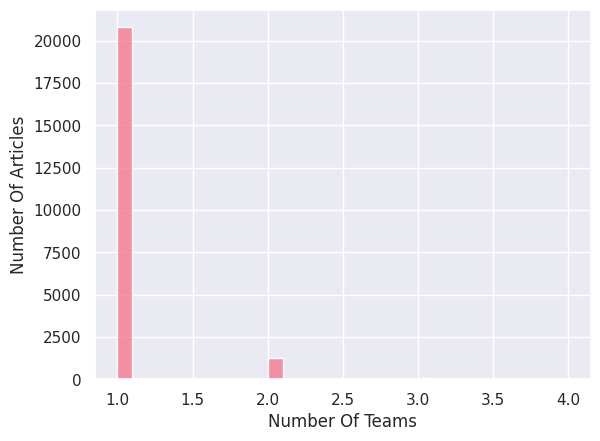

In [17]:
ax = sns.histplot(
    data = data['teams'].apply(len).reset_index(),
    x = "teams",
    bins=30
)

_ = ax.set_xlabel("Number Of Teams")
_ = ax.set_ylabel("Number Of Articles")

- Number of Articles / Team

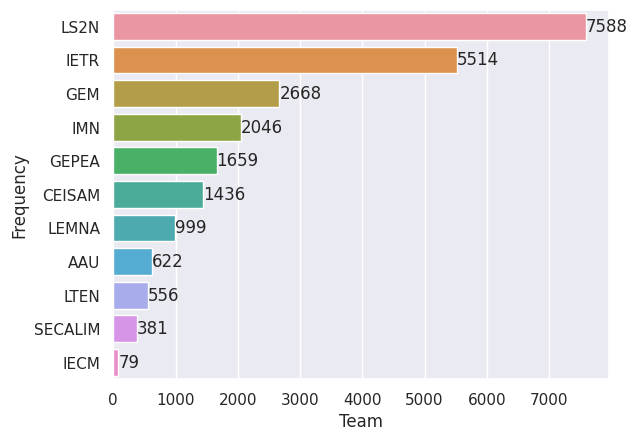

In [18]:
ax = sns.barplot(
    data = teams.sort_values(by="count", ascending=False),
    x = "count",
    y = "index",
)

for container in ax.containers:
    ax.bar_label(container)

_ = ax.set_xlabel("Team")
_ = ax.set_ylabel("Frequency")

- Teams Co-occurence

In [19]:
teams = teams['index'].tolist()
cooccurance = np.zeros((len(teams), len(teams)))

for i,team1 in enumerate(teams):
    for j,team2 in enumerate(teams):

        if i <= j:
            mask = data['teams'].apply(lambda x : team1 in x) & data['teams'].apply(lambda x : team2 in x)
            cooccurance[i, j] = mask.sum().item()
            cooccurance[j, i] = cooccurance[i, j]

cooccurance = pd.DataFrame(data=cooccurance, columns=teams, index=teams)

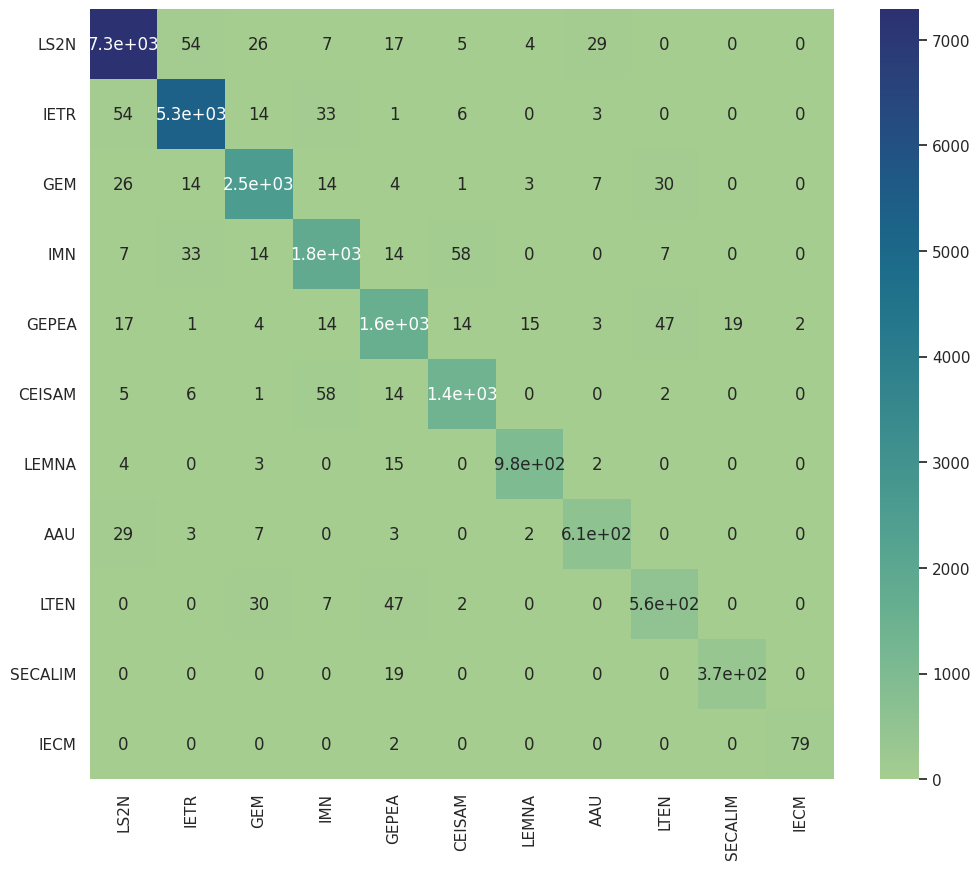

In [20]:
ax = sns.heatmap(cooccurance, annot=True, cmap='crest')
ax.figure.set_size_inches(12, 10)

### Date

- Number Of Articles / Year

In [21]:
year = data['date'].apply(lambda x : x.year).value_counts()
YEAR = 2005
n = year.iloc[year.index <= YEAR].sum()
year = year.drop(index=year.index[year.index <= YEAR])
year.index = year.index.astype(str)
year.loc[f"{YEAR} <="] = n
year = year.reset_index() \
    .rename(columns={ "date" : "Year", "count" : "Number Of Articles" }) \
    .sort_values("Year", ascending=False)

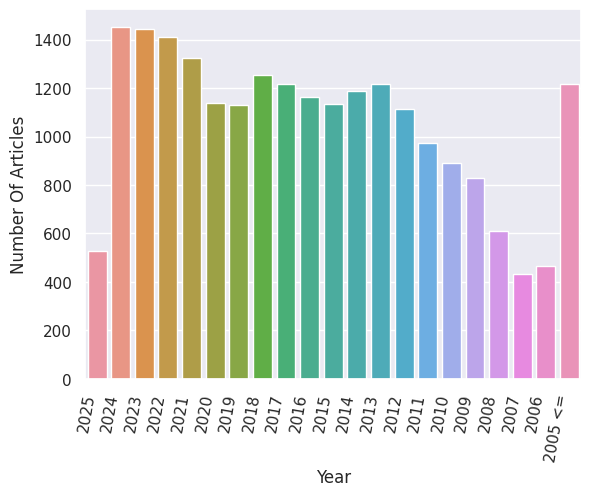

In [22]:
ax = sns.barplot(
    data = year,
    x = "Year",
    y = "Number Of Articles"
)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=80, ha="right")

- Fraction Of Articles For Each Year By Team

In [23]:
teams = set(reduce(lambda a,b : a + b, data['teams'].tolist()))
years = set(data['date'].apply(lambda x : x.year).tolist())

df = []

for team in teams:

    mask1 = data['teams'].apply(lambda x : team in x)

    for year in years:
        
        mask2 = data['date'].apply(lambda x : x.year == year)

        df.append({
            "team" : team,
            "year" : year,
            "fraction" : sum(mask1 & mask2) / sum(mask1)
        })

df = pd.DataFrame(df)

In [24]:
df_before_YEAR = df[df['year'] <= YEAR].groupby(by='team').sum().reset_index()
df_before_YEAR['year'] = 2005
df = pd.concat([
    df.drop(index=df.index[df['year'] <= YEAR]),
    df_before_YEAR
])

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

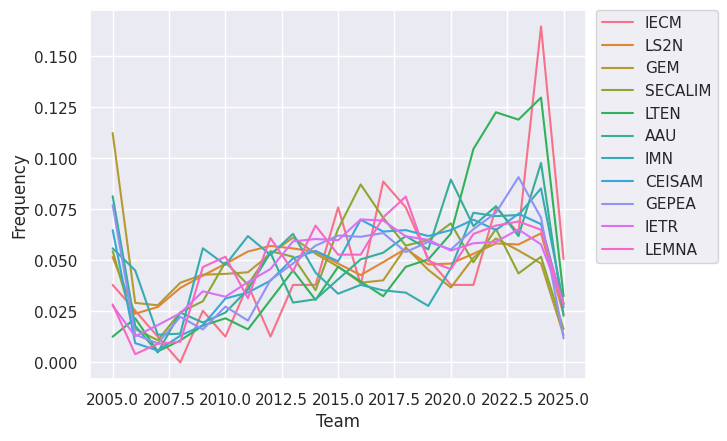

In [25]:
ax = sns.lineplot(
    data = df,
    x = "year",
    y = "fraction",
    hue = "team"
)

_ = ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
_ = ax.set_xlabel("Team")
_ = ax.set_ylabel("Frequency")

### Keywords

In [26]:
keywords = pd.Series(reduce(lambda a,b : a+b,data['keywords'].tolist())) \
    .value_counts() \
    .reset_index() 

- Number Of Keywords / Article

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


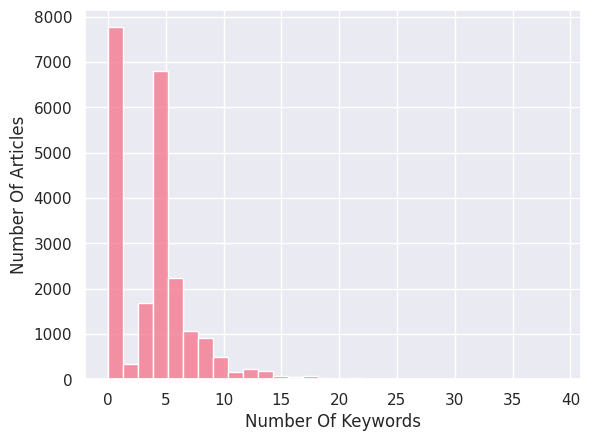

In [27]:
ax = sns.histplot(
    data = data["keywords"].apply(len).reset_index(),
    x = "keywords",
    bins = 30
)

_ = ax.set_xlabel("Number Of Keywords")
_ = ax.set_ylabel("Number Of Articles")

- Top 15 Most Fequent Keywords

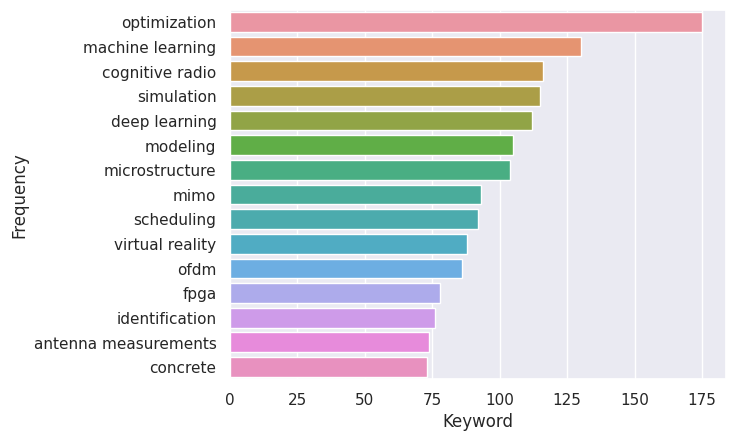

In [28]:
ax = sns.barplot(
    data = keywords.nlargest(15, columns="count").sort_values(by="count", ascending=False),
    y = "index",
    x = "count",
)

_ = ax.set_xlabel("Keyword")
_ = ax.set_ylabel("Frequency")

- Keywords World Cloud

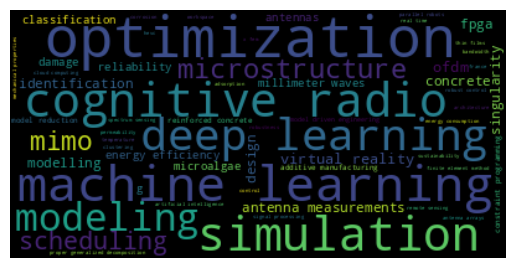

In [29]:
wordcloud = WordCloud().generate_from_frequencies(keywords.set_index("index").get("count").to_dict())

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

- Keywords Worldcloud / Team

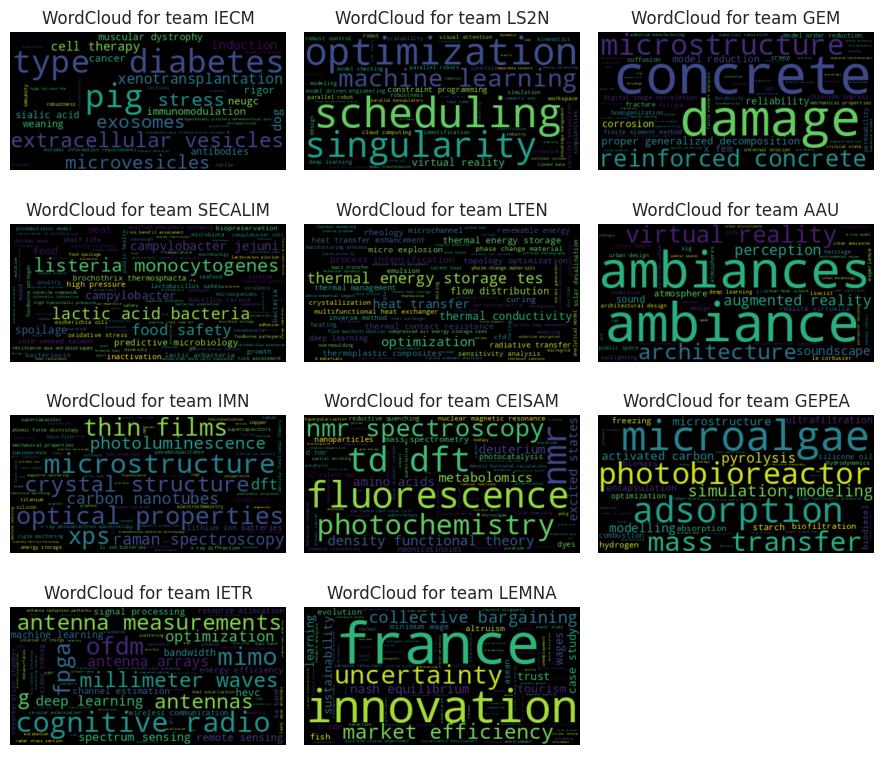

In [30]:
fig, axes = plt.subplots(nrows = 4, ncols = 3)

for i,team in enumerate(teams):

    j = i // 3
    k = i % 3

    subset = data[data['teams'].apply(lambda x: team in x)]

    keywords = pd.Series(reduce(lambda a,b : a+b, subset['keywords'].tolist())).value_counts()
    wordcloud = WordCloud().generate_from_frequencies(keywords.to_dict())

    axes[j,k].imshow(wordcloud, interpolation='bilinear')
    axes[j,k].axis("off")
    axes[j,k].set_title(f"WordCloud for team {team}")

axes[3, 2].axis("off")

fig.set_size_inches(9, 8)
plt.tight_layout()
plt.show()

### Venue

In [31]:
def get_venues(venues : list[str]) -> list[str]:

    ### Venues are encoded as follows
    ### venue-lvl1.venue-lvl2...etc
    sub_venues = []

    for venue in venues:

        for sub_venue in venue.split('.'):
            
            if len(sub_venues) == 0:
                sub_venues.append(sub_venue)
            else:
                sub_venues.append(sub_venues[-1]+'.'+sub_venue)

    return list(set(sub_venues))

In [32]:
venue = pd.Series(reduce(lambda a,b : a+b,data['venue'].apply(get_venues).tolist())) \
    .value_counts() \
    .reset_index() \
    .rename(columns = { "index" : "Venue", "count" : "Frequency" })

venue['Level'] = venue["Venue"].apply(lambda x : len(x.split('.')))

- Top Venues From first three levels

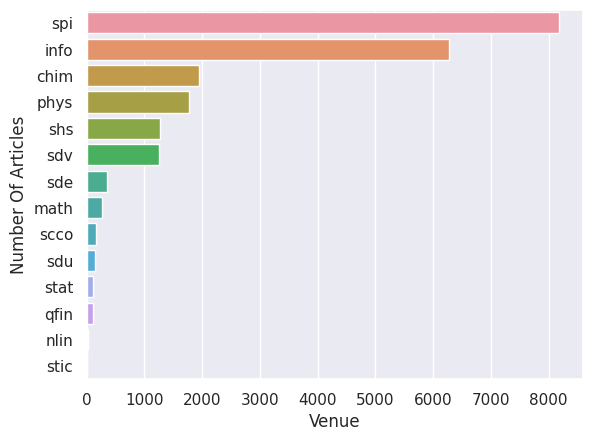

In [33]:
ax = sns.barplot(
    data = venue[venue["Level"] == 1].sort_values("Frequency", ascending=False),
    y = "Venue",
    x = "Frequency",
)

_ = ax.set_xlabel("Venue")
_ = ax.set_ylabel("Number Of Articles")

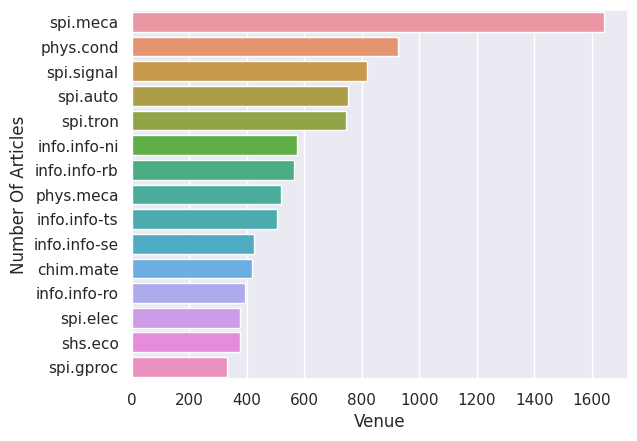

In [34]:
ax = sns.barplot(
    data = venue[venue["Level"] == 2].nlargest(15, "Frequency").sort_values("Frequency", ascending=False),
    y = "Venue",
    x = "Frequency",
)

_ = ax.set_xlabel("Venue")
_ = ax.set_ylabel("Number Of Articles")

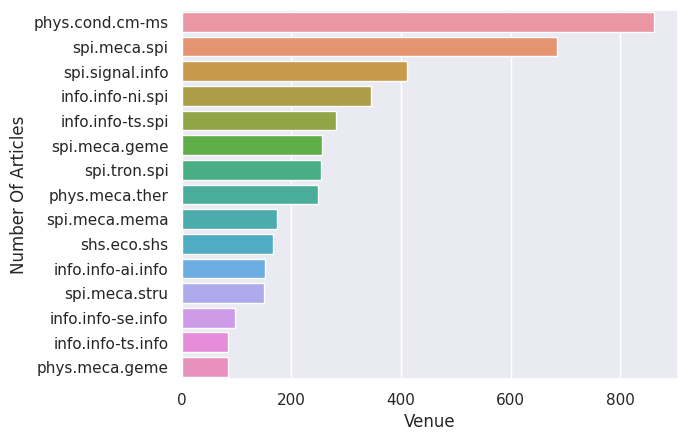

In [35]:
ax = sns.barplot(
    data = venue[venue["Level"] == 3].nlargest(15, "Frequency").sort_values("Frequency", ascending=False),
    y = "Venue",
    x = "Frequency",
)

_ = ax.set_xlabel("Venue")
_ = ax.set_ylabel("Number Of Articles")

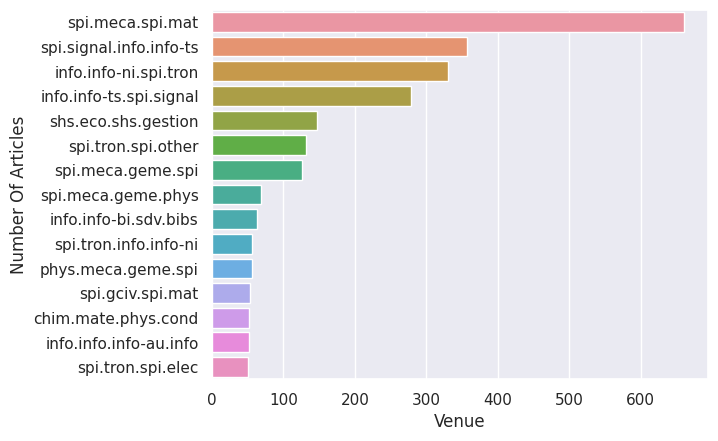

In [36]:
ax = sns.barplot(
    data = venue[venue["Level"] == 4].nlargest(15, "Frequency").sort_values("Frequency", ascending=False),
    y = "Venue",
    x = "Frequency",
)

_ = ax.set_xlabel("Venue")
_ = ax.set_ylabel("Number Of Articles")

- Venues WorldClouds

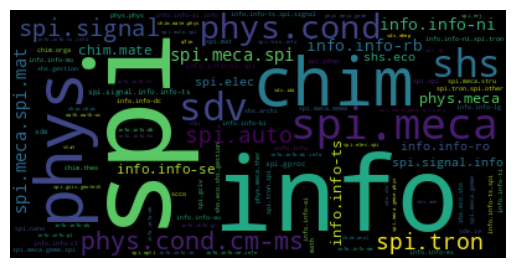

In [37]:
wordcloud = WordCloud().generate_from_frequencies(venue.set_index("Venue").get("Frequency").to_dict())

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

- Venue WordCloud / Team

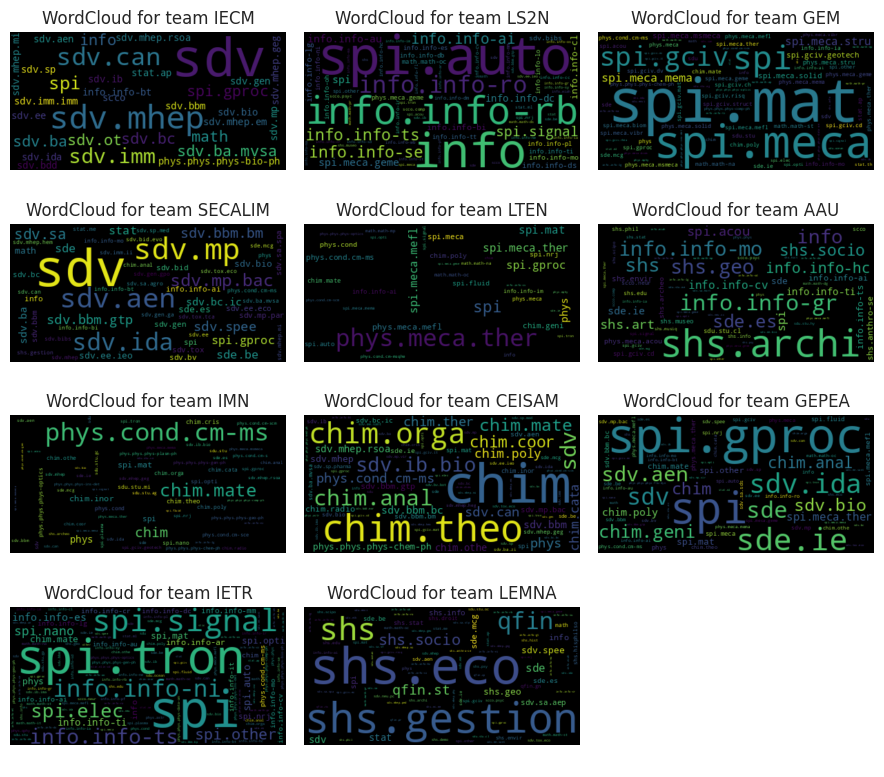

In [38]:
fig, axes = plt.subplots(nrows = 4, ncols = 3)

for i,team in enumerate(teams):

    j = i // 3
    k = i % 3

    subset = data[data['teams'].apply(lambda x: team in x)]

    keywords = pd.Series(reduce(lambda a,b : a+b, subset['venue'].tolist())).value_counts()
    wordcloud = WordCloud().generate_from_frequencies(keywords.to_dict())

    axes[j,k].imshow(wordcloud, interpolation='bilinear')
    axes[j,k].axis("off")
    axes[j,k].set_title(f"WordCloud for team {team}")

axes[3, 2].axis("off")

fig.set_size_inches(9, 8)
plt.tight_layout()
plt.show()

### Authors

In [39]:
teams = pd.Series(reduce(lambda a,b : a+b,data['authors'].tolist())) \
    .value_counts() \
    .reset_index() 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


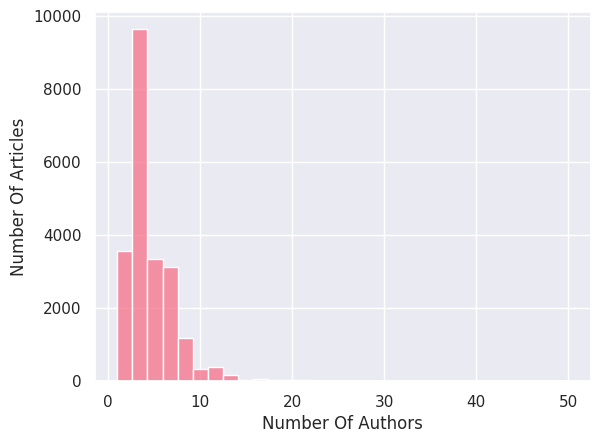

In [40]:
ax = sns.histplot(
    data = data['authors'].apply(len)
        .reset_index()
        .query("authors <= 50"), ### Ignore Articles with number of authors <= 50 as they impact the quality of the histogram chart
    x = "authors",
    bins = 30
)

_ = ax.set_xlabel("Number Of Authors")
_ = ax.set_ylabel("Number Of Articles")

### Text : Title & Abstract

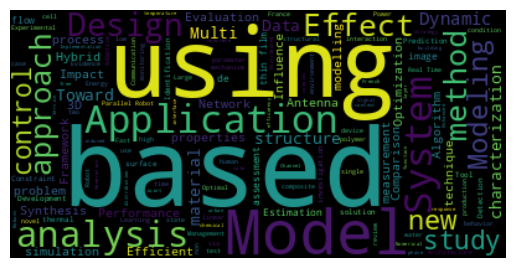

In [41]:
text = ' '.join(data.title)

wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

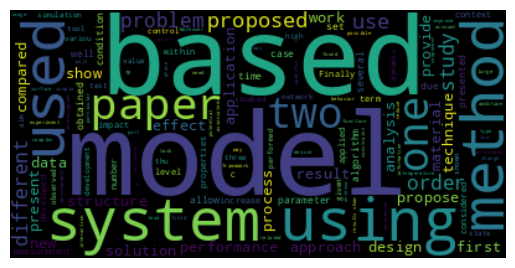

In [42]:
text = ' '.join(data.abstract)

wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [43]:
teams = list(set(reduce(lambda a,b: a + b, data['teams'])))

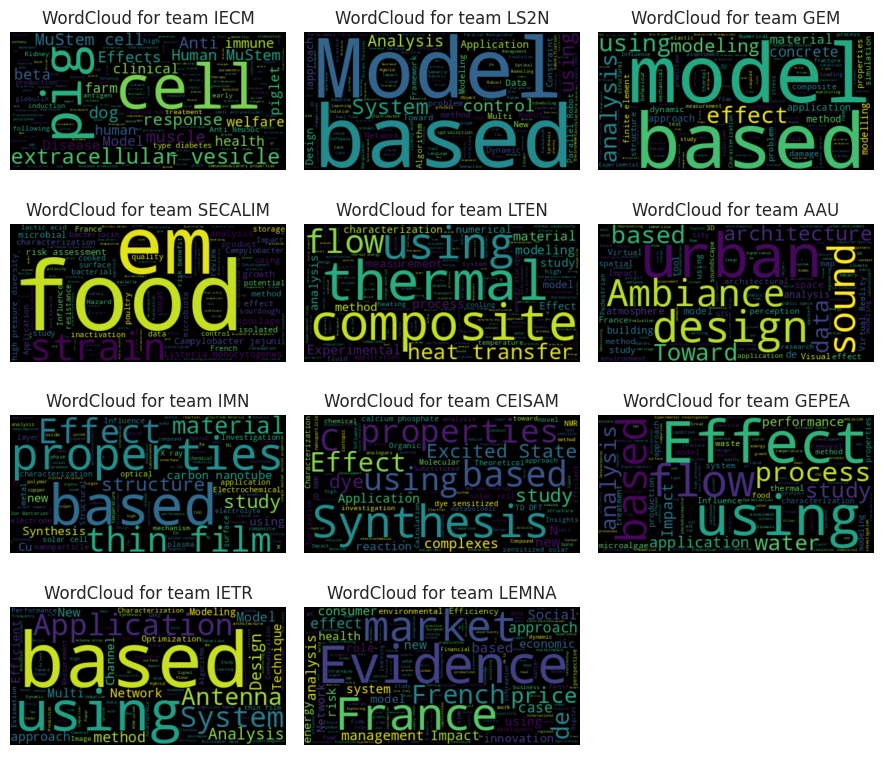

In [44]:
fig, axes = plt.subplots(nrows = 4, ncols = 3)

for i,team in enumerate(teams):

    j = i // 3
    k = i % 3

    subset = data[data['teams'].apply(lambda x: team in x)]
    text = ' '.join(subset.title)
    
    wordcloud = WordCloud().generate(text)

    axes[j,k].imshow(wordcloud, interpolation='bilinear')
    axes[j,k].axis("off")
    axes[j,k].set_title(f"WordCloud for team {team}")

axes[3, 2].axis("off")

fig.set_size_inches(9, 8)
plt.tight_layout()
plt.show()

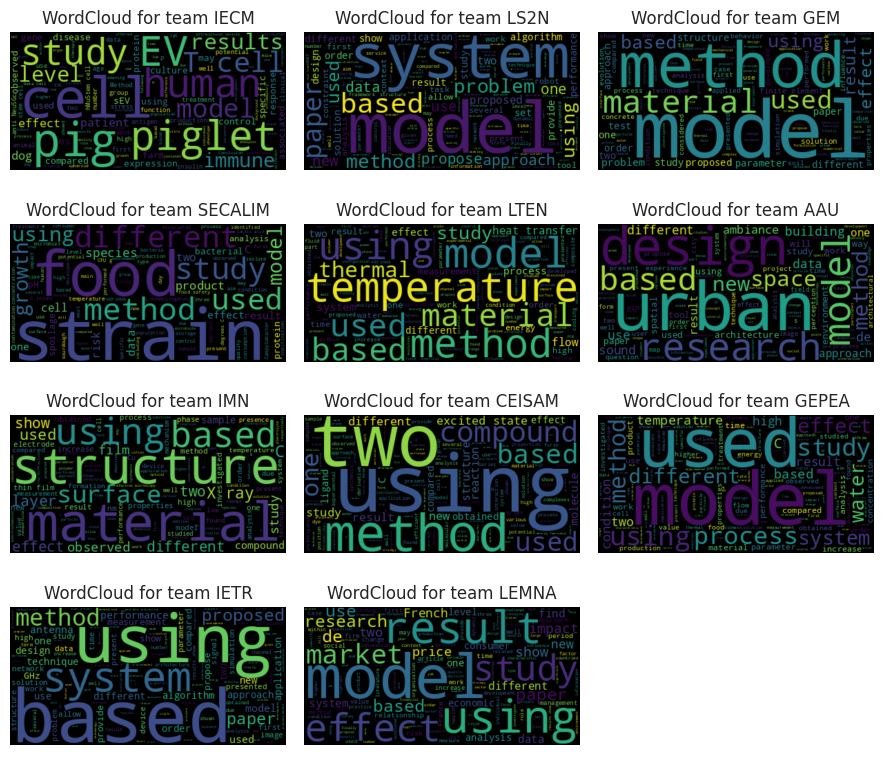

In [45]:
fig, axes = plt.subplots(nrows = 4, ncols = 3)

for i,team in enumerate(teams):

    j = i // 3
    k = i % 3

    subset = data[data['teams'].apply(lambda x: team in x)]
    text = ' '.join(subset.abstract)
    
    wordcloud = WordCloud().generate(text)

    axes[j,k].imshow(wordcloud, interpolation='bilinear')
    axes[j,k].axis("off")
    axes[j,k].set_title(f"WordCloud for team {team}")

axes[3, 2].axis("off")

fig.set_size_inches(9, 8)
plt.tight_layout()
plt.show()

<div id="graph_construction" >
    <h1 style="font-family:verdana;" > Graph Construction </h1>
</div>

<div id="feature_extraction" >
    <h2 style="font-family:verdana;" > Feature Extraction </h2>
</div>

To represent articles textual features as continuos vectors ready to be fed to Deep Neural Networks we will use SentenceTransformer a pre-trained model that allows us to extract sentence-level representations.

In [46]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2")
texts = (data["title"] + ", " + data["abstract"]).tolist()

X = model.encode(
    sentences=texts,
    device=DEVICE,
    batch_size=128,
    show_progress_bar=True,
    convert_to_tensor=True
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/173 [00:00<?, ?it/s]

<div id="relations_engineering" >
    <h2 style="font-family:verdana;" > Relations Engineering </h2>
</div>

A Graph implies the existence of relations between nodes, our data doesn't come with any explicit relations between individual articles, so we will be leveraging the metadata that comes with them to engineer two types of relations :

1. **common-author** : links two nodes if they share at least one author.
2. **common-keyword** : links two nodes if they share at least one keyword.

Since we will have two distinct types of relations then we will be dealing with a **Multi-Relational Graph**.

In [47]:
def get_adjecency_matrix(df : pd.DataFrame, col : str, min_freq : int = 1) -> Tensor:

    uniques = list(reduce(lambda a,b : a + b, df[col].tolist()))
    uniques = pd.Series(uniques).value_counts()
    uniques = uniques.index[uniques > min_freq].tolist()
    uniques_set = set(uniques)

    edge_index = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):

        for value in row[col]:
                
            if value in uniques_set:
                edge_index.append([idx, uniques.index(value)])

    row, col = torch.tensor(edge_index).t()

    A = SparseTensor(row = row, col = col)
    A = matmul(A, A.t())

    edge_index = gnn_utils.coalesce(gnn_utils.to_edge_index(A)[0])

    return edge_index

In [48]:
edge_index = []
edge_type = []
edge_types = ["keywords", "authors"]

for i,col in enumerate(edge_types):
    A = get_adjecency_matrix(data, col, min_freq=1)
    edge_index.append(A)
    edge_type.append(torch.ones_like(A[0]) * i)

edge_index = torch.cat(edge_index, dim = -1)
edge_type = torch.cat(edge_type)

100%|██████████| 22134/22134 [00:06<00:00, 3242.89it/s]


- Labels

In [49]:
Y = []

for team in teams:
    Y.append(data['teams'].apply(lambda x : team in x))

Y = torch.from_numpy(np.stack(Y, axis = 0)).t().long()

<div id="pyg" >
    <h2 style="font-family:verdana;" > Convert PyG Format </h2>
</div>

In [50]:
data = Data(x = X, edge_index = edge_index, edge_type = edge_type, y = Y).cpu()

In [51]:
print(f"Graph has a total of {data.num_nodes} Nodes and {data.num_features} Features.")
print(f"Graph has a total of {data.num_edges} Edge.")
print(f"The number of edges for each edge type is : ")
types_counts = torch.unique(data.edge_type, return_counts=True)

for i,count in torch.stack(types_counts, dim = 1):
    print(f'    - Number of edges of type {edge_types[i]} is : {count}.')

Graph has a total of 22134 Nodes and 384 Features.
Graph has a total of 2686395 Edge.
The number of edges for each edge type is : 
    - Number of edges of type keywords is : 606888.
    - Number of edges of type authors is : 2079507.


<div id="data_splitting" >
    <h1 style="font-family:verdana;" > Data Splitting </h1>
</div>

In [52]:
indices = torch.arange(data.num_nodes)
train_indices, val_indices = train_test_split(indices, test_size=0.2, shuffle=True)
train_indices, test_indices = train_test_split(train_indices, test_size=0.25, shuffle=True)

In [53]:
dtrain = data.subgraph(train_indices)
dval = data.subgraph(val_indices)
dtest = data.subgraph(test_indices)

<div id="modeling_training" >
    <h1 style="font-family:verdana;" > Modeling & Training </h1>
</div>

In [54]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [55]:
CONFIG = {
    "batch_size" : 128,
    "lr" : 1e-3,
    "weight_decay" : 1e-5,
    "epochs" : 20
}

<div id="utils" >
    <h2 style="font-family:verdana;" > Utils </h2>
</div>

In [56]:
GLOBAL_METRICS = {}
LABELS_METRICS = {}

In [57]:
def move_data_to_device(data : dict[str, Tensor], device : str) -> dict[str, Tensor]:

    for key, item in data.items():
        
        if isinstance(item, Tensor):
            data[key] = item.to(device)
        else:
            data[key] = move_data_to_device(item, device)

    return data

In [58]:
def train_iter(
    model : nn.Module,
    loader : DataLoader,
    device : str = DEVICE,
    optimizer : Optional[optim.Optimizer] = None,
    epoch : Optional[int] = None,
    phase : str = "train",
    return_preds : bool = False
) -> tuple[dict, np.ndarray | None]:
    
    is_train = phase == "train"
    model.train(is_train)

    running_loss = 0.0

    Y = []
    Y_hat = []

    for batch in tqdm(loader):

        with torch.set_grad_enabled(is_train):

            batch = move_data_to_device(batch, device=device)
            y = batch.pop('y').float()

            logits = model.forward(**batch)
            probas = torch.sigmoid(logits)

            B = loader.batch_size
            loss = F.binary_cross_entropy_with_logits(logits[:B], y[:B])

            if is_train and optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * y.size(0) / len(loader.dataset)

            Y.append(y[:B].detach().cpu())
            Y_hat.append(probas[:B].detach().cpu())

    Y = torch.cat(Y, dim = 0).numpy()
    Y_hat = torch.cat(Y_hat, dim = 0).numpy()
    Y_hard = (Y_hat > 0.5).astype(int)

    accuracy = accuracy_score(Y, Y_hard)
    h_loss = hamming_loss(Y, Y_hard)
    f1 = f1_score(Y, Y_hard, average="macro", zero_division=0.0)
    precision = precision_score(Y, Y_hard, average="macro", zero_division=0.0)
    recall = recall_score(Y, Y_hard, average="macro", zero_division=0.0)
    auc = roc_auc_score(Y, Y_hard, average="macro")

    record = {
        "Phase" : phase,
        "Loss" : running_loss,
        "Accuracy" : accuracy,
        "Macro F1-Score" : f1,
        "Precision" : precision,
        "Recall" : recall,
        "AUC" : auc.item(),
        "Hamming Loss" : h_loss
    }

    if epoch is not None:
        record["Epoch"] = epoch

    if return_preds:
        return record, Y_hat

    return record


In [59]:
def train(
    model : nn.Module,
    loaders : dict[str, DataLoader],
    lr : float,
    weight_decay : float,
    device : str,
    epochs : int,
    log_every : int = 5
) -> pd.DataFrame:
    
    print("*" * 156)
    print('*' * 69 + " Training Started " + "*" * 69)
    print("*" * 156)
    
    model = model.to(device)
    optimizer = optim.Adam(params = model.parameters(), lr=lr, weight_decay=weight_decay)
    history = []

    for epoch in range(epochs):

        for phase in ['train', 'val']:

            results = train_iter(
                model = model,
                loader = loaders[phase],
                optimizer = optimizer,
                device = device,
                epoch = epoch,
                phase = phase
            )

            history.append(results)

            if (epoch + 1) % log_every == 0:

                message = (
                    f'Epoch = {epoch+1}/{epochs} | Phase = {phase} | Accuracy = {results["Accuracy"]} | Macro F1-Score = {results["Macro F1-Score"]} | '
                    f'AUC = {results["AUC"]} | Loss = {results["Loss"]}'
                )

                print("*" * 156)
                print(message)
                print("*" * 156)

    return pd.DataFrame(history)

In [60]:
def get_label_wise_metrics(
    Y : np.ndarray,
    Y_prob : np.ndarray,
    labels : list[str]
) -> pd.DataFrame:

    label_wise_metrics = []

    for label in range(Y.shape[-1]):
            
        y_hard = np.int32(Y_prob > 0.5)
            
        label_wise_metrics.append({
            "team" : labels[label],
            "accuracy" : accuracy_score(Y[:,label], y_hard[:,label]),
            "f1_score" : f1_score(Y[:,label], y_hard[:,label]),
            "precision" : precision_score(Y[:,label], y_hard[:,label]),
            "recall" : recall_score(Y[:,label], y_hard[:,label]),
            "auc" : roc_auc_score(Y[:,label], Y_prob[:,label])
        })

    return pd.DataFrame(label_wise_metrics)

In [61]:
def plot_metric(eval_df : pd.DataFrame, metric : str, color : Optional[str] = None) -> None:

    ax = sns.barplot(
        data = eval_df.sort_values(by=metric, ascending=False),
        x = metric,
        y = "team",
        hue = color
    )

    ax.set_title(f"{metric.capitalize()} / Label")
    ax.set_xlabel(metric.capitalize())
    ax.set_ylabel("Team")
    
    ax.set(xlim = (int(eval_df[metric].min() * 10) / 10 - 0.05, 1.0))
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    text_pos = 0.5
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')

In [62]:
def plot_cms(Y : np.ndarray, Y_hat : np.ndarray, teams : list[str]) -> None:

    fig, axes = plt.subplots(nrows = 4, ncols = 3)
    Y_hard = np.int32(Y_hat > 0.5)

    for label in range(Y.size(-1)):

        j = label // 3
        k = label % 3

        cm = confusion_matrix(Y[:,label], Y_hard[:,label])
        cm = pd.DataFrame(data=cm,index=["N", "P"],columns=["N","P"])

        sns.heatmap(data=cm, ax=axes[j, k], cmap='crest', annot=True)
        axes[j, k].set_title(f"Label : {teams[label]}")

    axes[3, 2].axis("off")

    fig.set_size_inches(9, 9)
    plt.tight_layout()
    plt.show()

<div id="mlp" >
    <h2 style="font-family:verdana;" > Multi-Layer Perceptron </h2>
</div>

### Model

In [63]:
class MLP(nn.Module):

    def __init__(self, 
        in_dim : int,
        hidden_dim : int,
        num_layers : int,
        out_dim : int,
        act : Callable[[Tensor], Tensor] = F.relu,
        out_act : Callable[[Tensor], Tensor] = nn.Identity()
    ) -> None:
        super().__init__()

        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers,
        self.out_dim = out_dim
        self.act = act
        self.out_act = out_act

        self.layers = nn.ModuleList([
            nn.Linear(in_dim if i == 0 else hidden_dim, hidden_dim)
            for i in range(num_layers)
        ])

        self.head = nn.Linear(hidden_dim, out_dim)

    def forward(self, x : Tensor) -> Tensor:

        for layer in self.layers:
            x = self.act(layer(x))

        return self.out_act(self.head(x))

In [64]:
model = MLP(
    in_dim=384,
    hidden_dim=192,
    num_layers=3,
    out_dim=11,
    act=F.relu
).cpu()

In [65]:
summary(model, input_size=(16, 384))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [16, 11]                  --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [16, 192]                 73,920
│    └─Linear: 2-2                       [16, 192]                 37,056
│    └─Linear: 2-3                       [16, 192]                 37,056
├─Linear: 1-2                            [16, 11]                  2,123
├─Identity: 1-3                          [16, 11]                  --
Total params: 150,155
Trainable params: 150,155
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.40
Input size (MB): 0.02
Forward/backward pass size (MB): 0.08
Params size (MB): 0.60
Estimated Total Size (MB): 0.70

### Dataloaders

In [66]:
class TensorDataset(Dataset):

    def __init__(self, x : Tensor, y : Tensor) -> None:

        self.x = x
        self.y = y

    def __len__(self) -> int:
        return self.x.size(0)

    def __getitem__(self, index : int) -> dict[str, Tensor]:
        x, y = self.x[index,:], self.y[index,:]
        return { "x" : x, "y" : y }

In [67]:
train_loader = DataLoader(
    dataset = TensorDataset(dtrain.x, dtrain.y),
    batch_size = CONFIG['batch_size'],
    shuffle = True,
    drop_last = True,
    num_workers = 4,
    prefetch_factor = 2
)

val_loader = DataLoader(
    dataset = TensorDataset(dval.x, dval.y),
    batch_size = CONFIG['batch_size'],
    shuffle = False,
    drop_last = False,
    num_workers = 4,
    prefetch_factor = 2
)

test_loader = DataLoader(
    dataset = TensorDataset(dtest.x, dtest.y),
    batch_size = CONFIG['batch_size'],
    shuffle = False,
    drop_last = False,
    num_workers = 4,
    prefetch_factor = 2
)

### Training

In [68]:
history = train(
    model = model,
    loaders = {  
        "train" : train_loader,
        "val" : val_loader
    },
    lr = CONFIG['lr'],
    weight_decay = CONFIG['weight_decay'],
    device = DEVICE,
    epochs = CONFIG['epochs']
)

************************************************************************************************************************************************************
********************************************************************* Training Started *********************************************************************
************************************************************************************************************************************************************


100%|██████████| 103/103 [00:00<00:00, 171.76it/s]


************************************************************************************************************************************************************
Epoch = 5/20 | Phase = train | Accuracy = 0.8171268203883495 | Macro F1-Score = 0.6965973439008893 | AUC = 0.8316658804312776 | Loss = 0.06731273779668002
************************************************************************************************************************************************************


100%|██████████| 35/35 [00:00<00:00, 122.36it/s]


************************************************************************************************************************************************************
Epoch = 5/20 | Phase = val | Accuracy = 0.817483623221143 | Macro F1-Score = 0.6913535381961774 | AUC = 0.830054752065407 | Loss = 0.0705362670779942
************************************************************************************************************************************************************


100%|██████████| 103/103 [00:00<00:00, 170.52it/s]


************************************************************************************************************************************************************
Epoch = 10/20 | Phase = train | Accuracy = 0.8979824029126213 | Macro F1-Score = 0.8115931066303997 | AUC = 0.8925929067865094 | Loss = 0.038436223620391764
************************************************************************************************************************************************************


100%|██████████| 35/35 [00:00<00:00, 122.28it/s]


************************************************************************************************************************************************************
Epoch = 10/20 | Phase = val | Accuracy = 0.8416534899480461 | Macro F1-Score = 0.7538283346212563 | AUC = 0.855590951085442 | Loss = 0.06556460625038261
************************************************************************************************************************************************************


100%|██████████| 103/103 [00:00<00:00, 168.99it/s]


************************************************************************************************************************************************************
Epoch = 15/20 | Phase = train | Accuracy = 0.9578276699029126 | Macro F1-Score = 0.946440726303278 | AUC = 0.9622875105803704 | Loss = 0.016031952350434052
************************************************************************************************************************************************************


100%|██████████| 35/35 [00:00<00:00, 118.01it/s]


************************************************************************************************************************************************************
Epoch = 15/20 | Phase = val | Accuracy = 0.8434605827874407 | Macro F1-Score = 0.8167324862470278 | AUC = 0.8862238066756519 | Loss = 0.07748855507202816
************************************************************************************************************************************************************


100%|██████████| 103/103 [00:00<00:00, 163.86it/s]


************************************************************************************************************************************************************
Epoch = 20/20 | Phase = train | Accuracy = 0.9882433252427184 | Macro F1-Score = 0.9891259273689988 | AUC = 0.9912056378800372 | Loss = 0.005719503861324611
************************************************************************************************************************************************************


100%|██████████| 35/35 [00:00<00:00, 105.57it/s]


************************************************************************************************************************************************************
Epoch = 20/20 | Phase = val | Accuracy = 0.843008809577592 | Macro F1-Score = 0.8233646778121532 | AUC = 0.8927936952491661 | Loss = 0.09447038559920905
************************************************************************************************************************************************************


### Evaluation

- Global Evaluation

In [69]:
results, Y_hat = train_iter(
    model=model,
    loader=test_loader,
    device=DEVICE,
    phase="test",
    return_preds=True
)

results.pop("Phase")
results.pop("Loss")

print("*" * 156)
print(' | '.join(f"{key} = {100 * value:.2f}%" for key,value in results.items()))
print("*" * 156)

100%|██████████| 35/35 [00:00<00:00, 113.27it/s]

************************************************************************************************************************************************************
Accuracy = 84.44% | Macro F1-Score = 82.12% | Precision = 87.07% | Recall = 79.78% | AUC = 89.26% | Hamming Loss = 2.18%
************************************************************************************************************************************************************


In [70]:
GLOBAL_METRICS['MLP'] = results

- Label-Wise Evaluation

In [71]:
teams = list(teams)

In [72]:
eval_df = get_label_wise_metrics(dtest.y, Y_hat, teams)
LABELS_METRICS['MLP'] = eval_df
eval_df

team  accuracy  f1_score  precision    recall       auc
0      IECM  0.997289  0.571429   1.000000  0.400000  0.992852
1      LS2N  0.943754  0.912045   0.906601  0.917555  0.981984
2       GEM  0.974701  0.885010   0.865462  0.905462  0.987680
3   SECALIM  0.994127  0.819444   0.797297  0.842857  0.996688
4      LTEN  0.987124  0.695187   0.792683  0.619048  0.967920
5       AAU  0.988706  0.813433   0.784173  0.844961  0.990071
6       IMN  0.972894  0.838275   0.856749  0.820580  0.983287
7    CEISAM  0.980574  0.850694   0.862676  0.839041  0.988957
8     GEPEA  0.976056  0.839879   0.871473  0.810496  0.982750
9      IETR  0.953241  0.903497   0.915014  0.892265  0.983077
10    LEMNA  0.991642  0.904393   0.925926  0.883838  0.995440

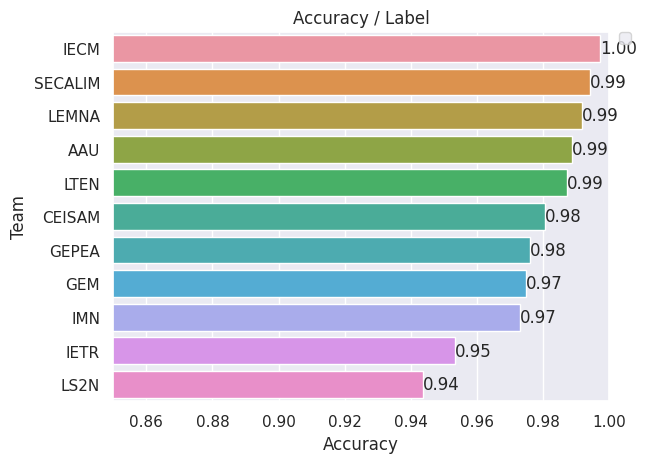

In [73]:
plot_metric(eval_df, metric="accuracy")

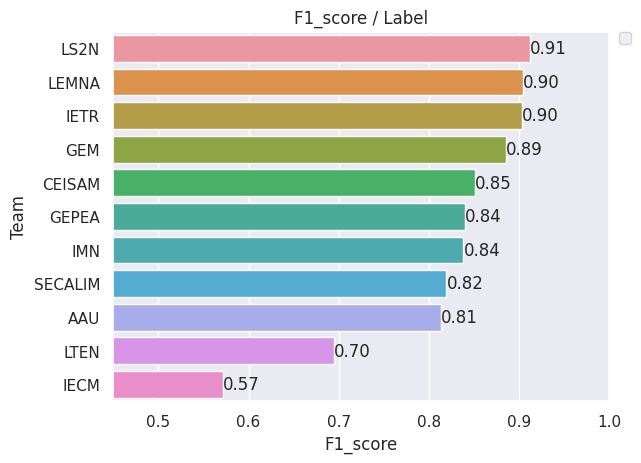

In [74]:
plot_metric(eval_df, metric="f1_score")

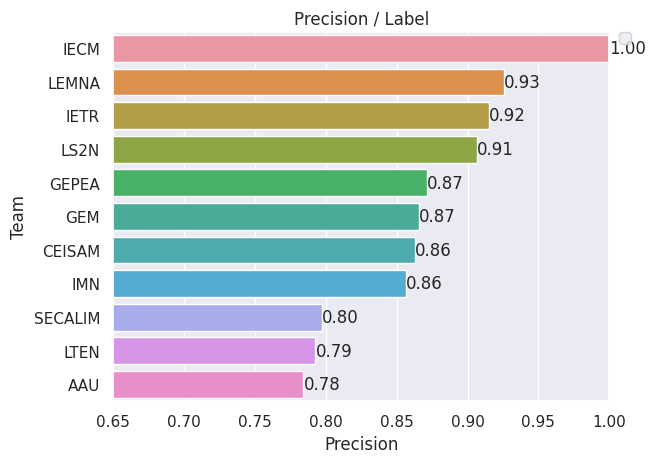

In [75]:
plot_metric(eval_df, metric="precision")

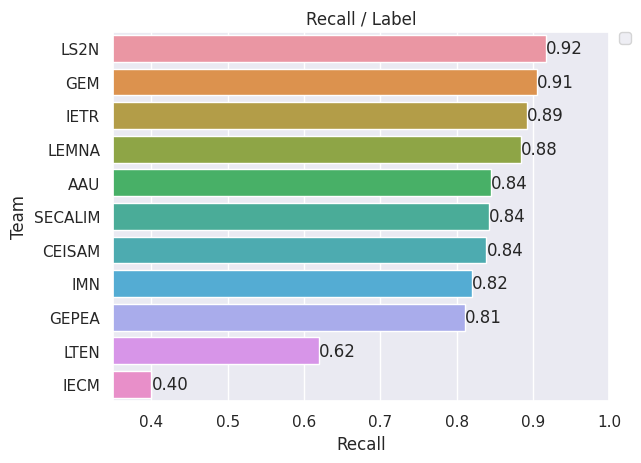

In [76]:
plot_metric(eval_df, metric="recall")

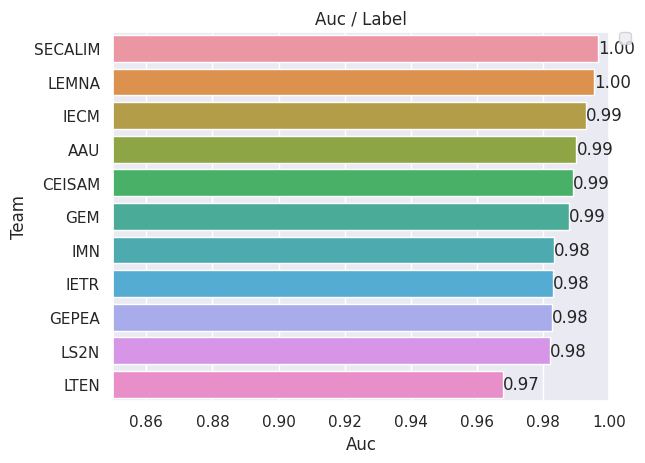

In [77]:
plot_metric(eval_df, metric="auc")

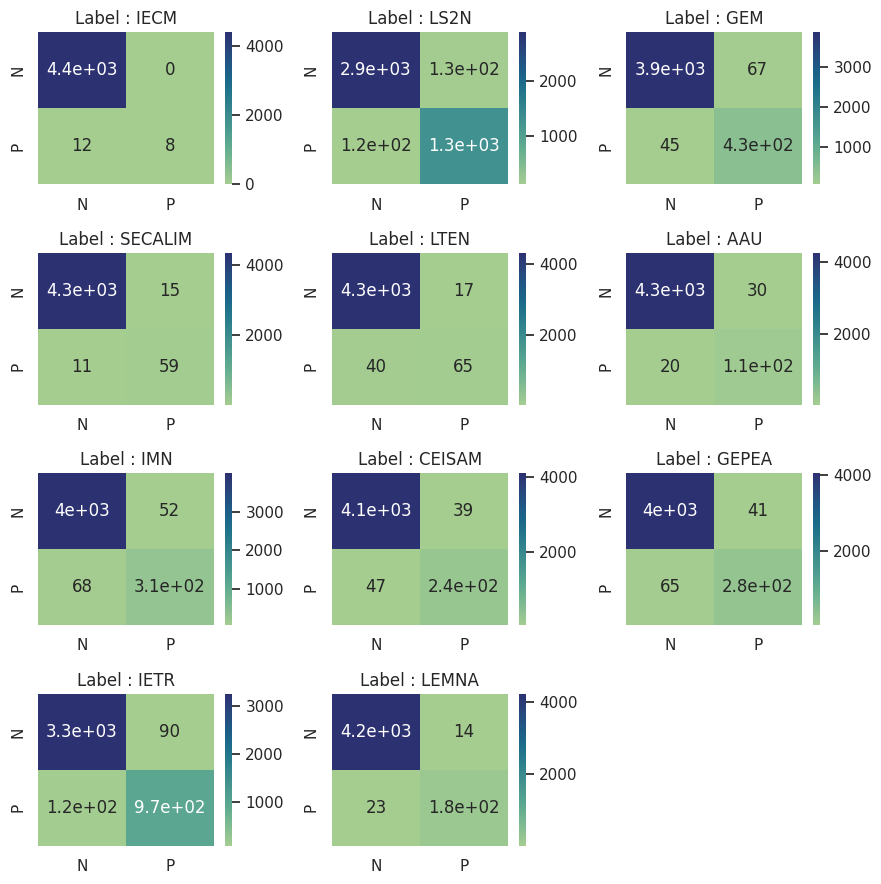

In [78]:
plot_cms(dtest.y, Y_hat, teams)

<div id="gnn" >
    <h2 style="font-family:verdana;" > Graph Neural Networks </h2>
</div>

### Model

In [79]:
class RGCNModel(nn.Module):

    def __init__(self, 
        in_dim : int,
        hidden_dim : int,
        num_layers : int,
        num_relations : int,
        out_dim : int,
        act : Callable[[Tensor], Tensor] = F.relu,
        out_act : Callable[[Tensor], Tensor] = nn.Identity()
    ) -> None:
        super().__init__()

        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers,
        self.out_dim = out_dim
        self.act = act
        self.out_act = out_act

        self.layers = nn.ModuleList([
            gnn.RGCNConv(in_dim if i == 0 else hidden_dim, hidden_dim, num_relations)
            for i in range(num_layers)
        ])

        self.jk = gnn.JumpingKnowledge(mode="max")

        self.head = nn.Linear(hidden_dim, out_dim)

    def forward(self, x : Tensor, edge_index : Tensor, edge_type : Tensor) -> Tensor:

        X = []

        for layer in self.layers:
            x = self.act(layer(x, edge_index, edge_type))
            X.append(x)

        x = self.jk(X)

        return self.out_act(self.head(x))

In [80]:
model = RGCNModel(
    in_dim=384,
    hidden_dim=192,
    num_layers=3,
    num_relations=2,
    out_dim=11,
    act=F.relu
).cpu()

In [81]:
B, D, N, E, R = 16, 384, 10, 30, 2

x = torch.randn(B, D)
edge_index = torch.randint(0, N, (2, E))
edge_type = torch.randint(0, R, (E,))


summary(model=model, input_data={ 
    "x" : x, 
    "edge_index" : edge_index, 
    "edge_type" : edge_type 
})

Layer (type:depth-idx)                   Output Shape              Param #
RGCNModel                                [16, 11]                  --
├─ModuleList: 1-1                        --                        --
│    └─RGCNConv: 2-1                     [16, 192]                 221,376
│    │    └─MeanAggregation: 3-1         [16, 384]                 --
│    │    └─MeanAggregation: 3-2         [16, 384]                 --
│    └─RGCNConv: 2-2                     [16, 192]                 110,784
│    │    └─MeanAggregation: 3-3         [16, 192]                 --
│    │    └─MeanAggregation: 3-4         [16, 192]                 --
│    └─RGCNConv: 2-3                     [16, 192]                 110,784
│    │    └─MeanAggregation: 3-5         [16, 192]                 --
│    │    └─MeanAggregation: 3-6         [16, 192]                 --
├─JumpingKnowledge: 1-2                  [16, 192]                 --
├─Linear: 1-3                            [16, 11]                  2,1

### DataLoaders

In [82]:
def transform(data : Data) -> dict[str, Tensor]:
    return {
        "x" : data.x,
        "edge_index" : data.edge_index,
        "edge_type" : data.edge_type,
        "y" : data.y
    }

In [83]:
train_loader = NeighborLoader(
    data = dtrain,
    num_neighbors=[10, 6, 6],
    batch_size = CONFIG['batch_size'],
    shuffle = True,
    drop_last = True,
    num_workers = 4,
    prefetch_factor = 2,
    transform = transform
)

val_loader = NeighborLoader(
    data = dval,
    num_neighbors=[10, 6, 6],
    batch_size = CONFIG['batch_size'],
    shuffle = False,
    drop_last = False,
    num_workers = 4,
    prefetch_factor = 2,
    transform = transform
)

test_loader = NeighborLoader(
    data = dtest,
    num_neighbors=[10, 6, 6],
    batch_size = CONFIG['batch_size'],
    shuffle = False,
    drop_last = False,
    num_workers = 4,
    prefetch_factor = 2,
    transform = transform
)

### Training

In [84]:
history = train(
    model = model,
    loaders = {  
        "train" : train_loader,
        "val" : val_loader
    },
    lr = CONFIG['lr'],
    weight_decay = CONFIG['weight_decay'],
    device = DEVICE,
    epochs = CONFIG['epochs']
)

************************************************************************************************************************************************************
********************************************************************* Training Started *********************************************************************
************************************************************************************************************************************************************


100%|██████████| 103/103 [00:03<00:00, 34.33it/s]


************************************************************************************************************************************************************
Epoch = 5/20 | Phase = train | Accuracy = 0.9444023058252428 | Macro F1-Score = 0.9356302480682802 | AUC = 0.9528830816465788 | Loss = 1.5114322838604204
************************************************************************************************************************************************************


100%|██████████| 35/35 [00:00<00:00, 54.78it/s]


************************************************************************************************************************************************************
Epoch = 5/20 | Phase = val | Accuracy = 0.9274553571428571 | Macro F1-Score = 0.9285585263074018 | AUC = 0.9500809437123433 | Loss = 0.9120787589238363
************************************************************************************************************************************************************


100%|██████████| 103/103 [00:03<00:00, 34.04it/s]


************************************************************************************************************************************************************
Epoch = 10/20 | Phase = train | Accuracy = 0.963061286407767 | Macro F1-Score = 0.96179403507963 | AUC = 0.9736637444100595 | Loss = 0.9565528857802228
************************************************************************************************************************************************************


100%|██████████| 35/35 [00:00<00:00, 53.72it/s]


************************************************************************************************************************************************************
Epoch = 10/20 | Phase = val | Accuracy = 0.9283482142857142 | Macro F1-Score = 0.9365809069672888 | AUC = 0.9574876817474071 | Loss = 0.9286464044676139
************************************************************************************************************************************************************


100%|██████████| 103/103 [00:02<00:00, 34.81it/s]


************************************************************************************************************************************************************
Epoch = 15/20 | Phase = train | Accuracy = 0.9731492718446602 | Macro F1-Score = 0.9760209439287625 | AUC = 0.9831808101476245 | Loss = 0.65051226822685
************************************************************************************************************************************************************


100%|██████████| 35/35 [00:00<00:00, 51.85it/s]


************************************************************************************************************************************************************
Epoch = 15/20 | Phase = val | Accuracy = 0.9348214285714286 | Macro F1-Score = 0.9407667591397613 | AUC = 0.962921002486278 | Loss = 0.9716451833593048
************************************************************************************************************************************************************


100%|██████████| 103/103 [00:02<00:00, 34.66it/s]


************************************************************************************************************************************************************
Epoch = 20/20 | Phase = train | Accuracy = 0.9792930825242718 | Macro F1-Score = 0.9844682681103035 | AUC = 0.989096548050961 | Loss = 0.5106773971918696
************************************************************************************************************************************************************


100%|██████████| 35/35 [00:00<00:00, 54.17it/s]

************************************************************************************************************************************************************
Epoch = 20/20 | Phase = val | Accuracy = 0.9321428571428572 | Macro F1-Score = 0.9355690289597195 | AUC = 0.9653373960983909 | Loss = 0.9779299283490639
************************************************************************************************************************************************************


### Evaluation

- Global Evaluation

In [85]:
results, Y_hat = train_iter(
    model=model,
    loader=test_loader,
    device=DEVICE,
    phase="test",
    return_preds=True
)

Y_hat = Y_hat[:dtest.num_nodes,:]
results.pop("Phase")
results.pop("Loss")

GLOBAL_METRICS['R-GCN'] = results

print("*" * 156)
print(' | '.join(f"{key} = {100 * value:.2f}%" for key,value in results.items()))
print("*" * 156)

100%|██████████| 35/35 [00:00<00:00, 52.64it/s]

************************************************************************************************************************************************************
Accuracy = 92.83% | Macro F1-Score = 93.10% | Precision = 94.61% | Recall = 91.90% | AUC = 95.67% | Hamming Loss = 0.89%
************************************************************************************************************************************************************


- Label-Wise Evaluation

In [86]:
eval_df = get_label_wise_metrics(dtest.y, Y_hat, teams)
LABELS_METRICS['R-GCN'] = eval_df
eval_df

team  accuracy  f1_score  precision    recall       auc
0      IECM  0.999096  0.888889   1.000000  0.800000  0.976526
1      LS2N  0.978315  0.966434   0.951136  0.982232  0.996720
2       GEM  0.991642  0.960428   0.978214  0.943277  0.996831
3   SECALIM  0.998871  0.963504   0.985075  0.942857  0.998413
4      LTEN  0.992546  0.849315   0.815789  0.885714  0.983226
5       AAU  0.995934  0.929134   0.944000  0.914729  0.997581
6       IMN  0.983736  0.900552   0.944928  0.860158  0.994605
7    CEISAM  0.988706  0.916107   0.898026  0.934932  0.993288
8     GEPEA  0.991190  0.942563   0.952381  0.932945  0.996578
9      IETR  0.984640  0.968779   0.966117  0.971455  0.995929
10    LEMNA  0.995934  0.953846   0.968750  0.939394  0.991258

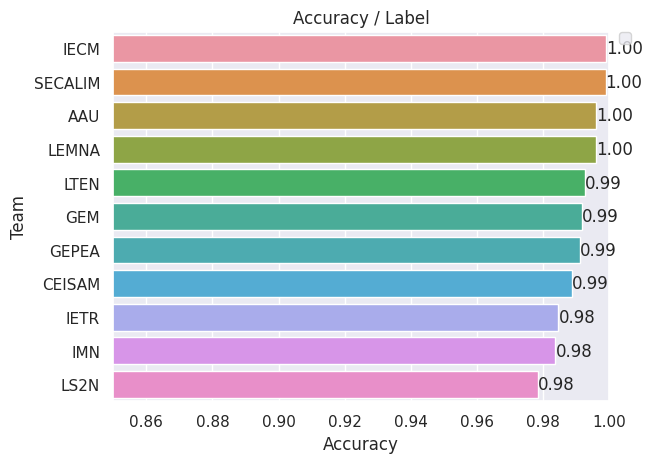

In [87]:
plot_metric(eval_df=eval_df, metric="accuracy")

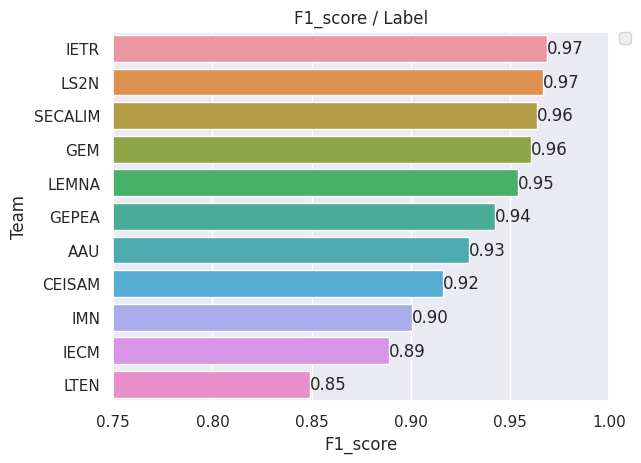

In [88]:
plot_metric(eval_df=eval_df, metric="f1_score")

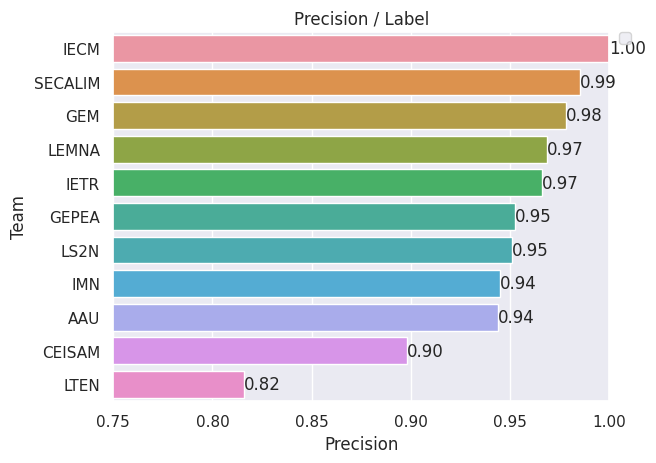

In [89]:
plot_metric(eval_df=eval_df, metric="precision")

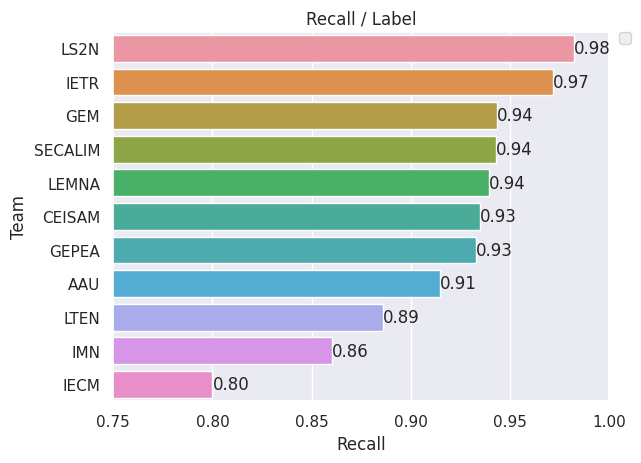

In [90]:
plot_metric(eval_df=eval_df, metric="recall")

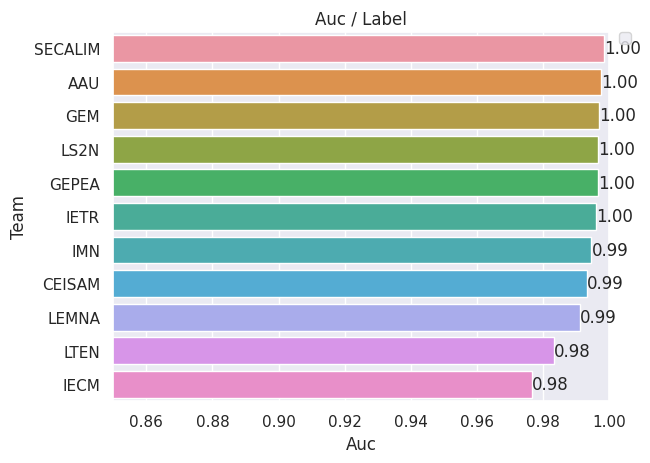

In [91]:
plot_metric(eval_df=eval_df, metric="auc")

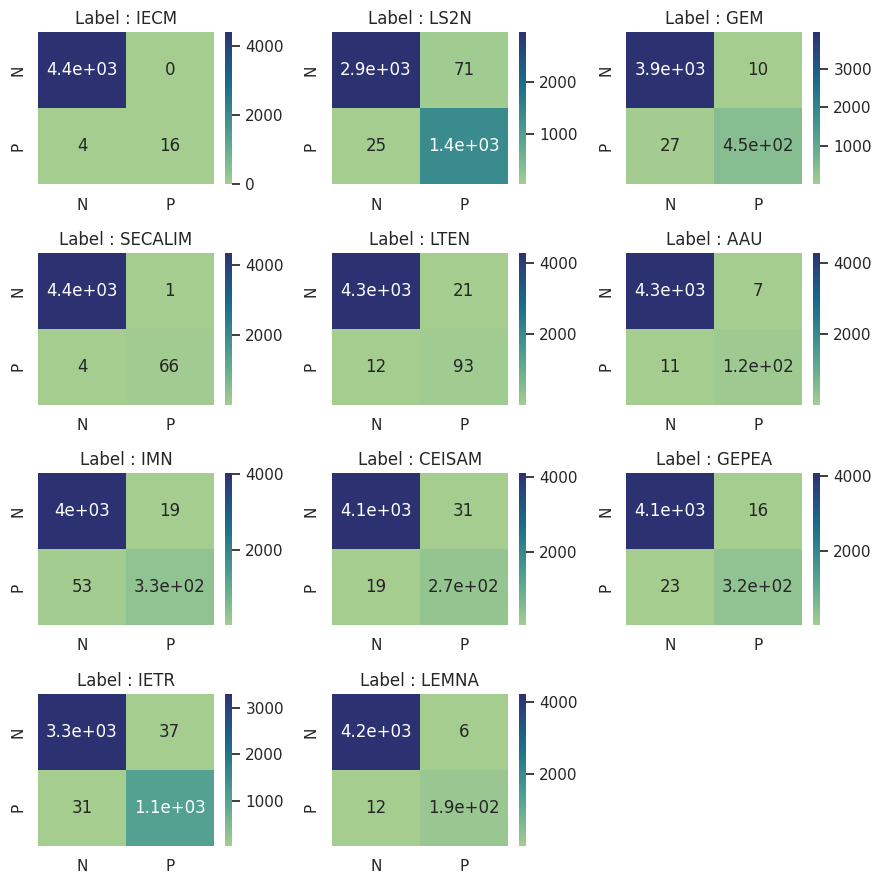

In [92]:
plot_cms(dtest.y, Y_hat, teams)

<div id="mlp_vs_gnn" >
    <h2 style="font-family:verdana;" > Side By Side Comparision : MLP Vs R-GCN </h2>
</div>

- Global Comparison

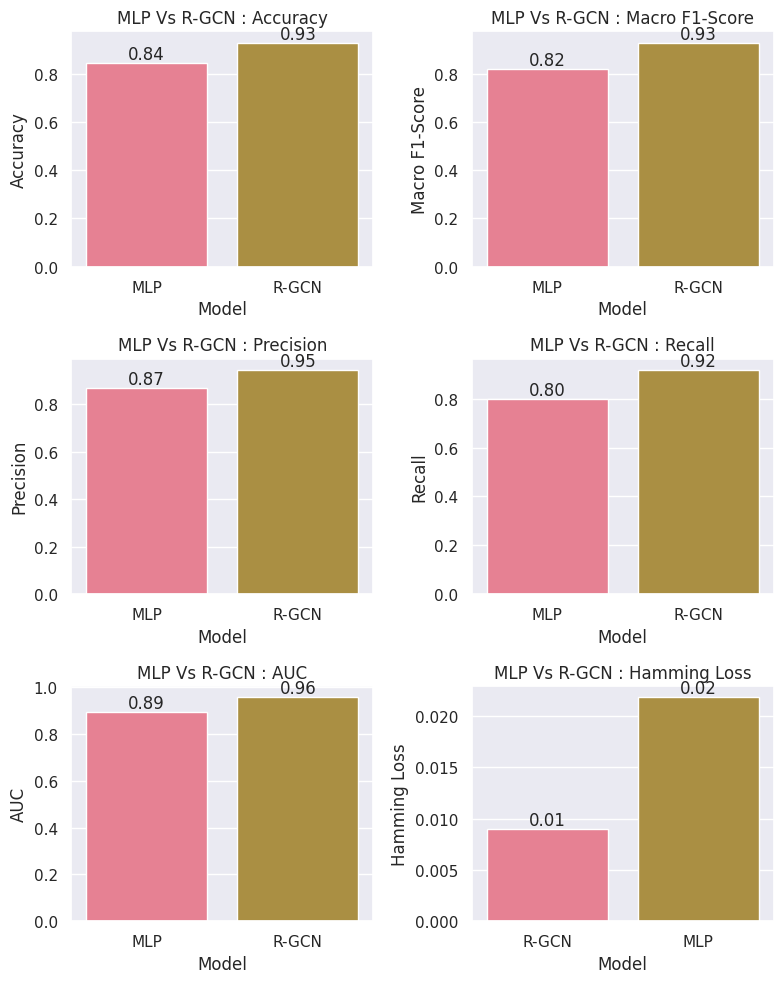

In [93]:
fig, axes = plt.subplots(nrows=3,ncols=2)

for i,metric in enumerate(GLOBAL_METRICS['MLP'].keys()):

    j = i // 2 
    k = i % 2

    df = pd.DataFrame(GLOBAL_METRICS) \
        .transpose() \
        .reset_index() \
        .rename(columns = { "index" : "Model" }) \
        .sort_values(by=metric)

    ax = sns.barplot(
        data = df,
        x = "Model",
        y = metric,
        ax = axes[j,k]
    )

    text_pos = 0.5
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')

    ax.set_title(f"MLP Vs R-GCN : {metric}")

fig.set_size_inches(8, 10)

plt.tight_layout()
plt.show()

- Label Wise Comparision

In [94]:
for key, df in LABELS_METRICS.items():
    df["Model"] = key

df = pd.concat(LABELS_METRICS.values())

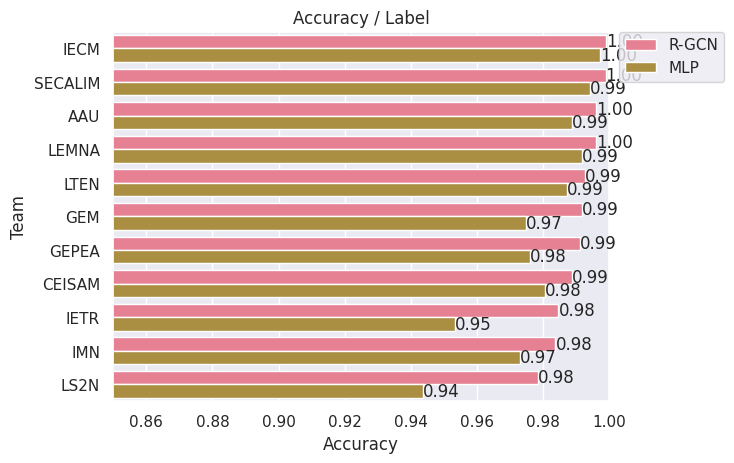

In [95]:
plot_metric(df, "accuracy", "Model")

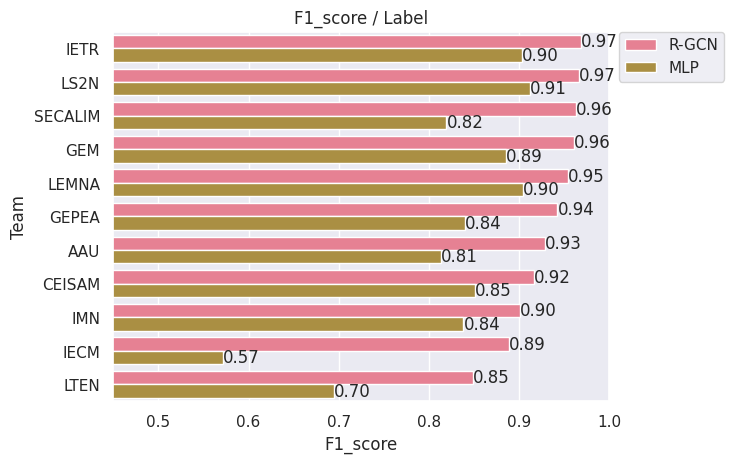

In [96]:
plot_metric(df, "f1_score", "Model")

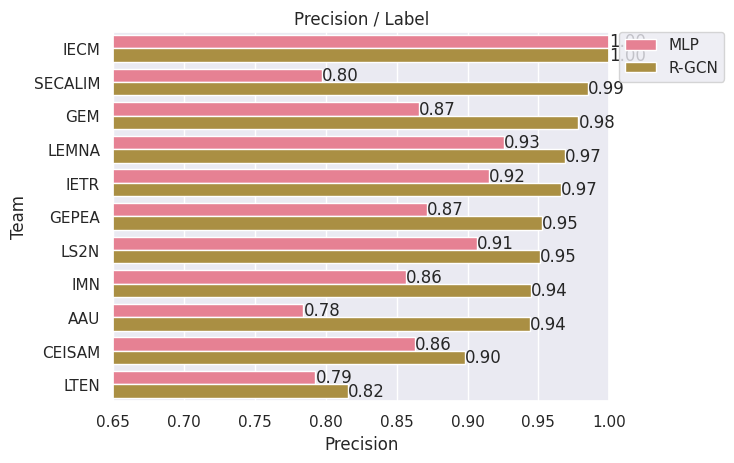

In [97]:
plot_metric(df, "precision", "Model")

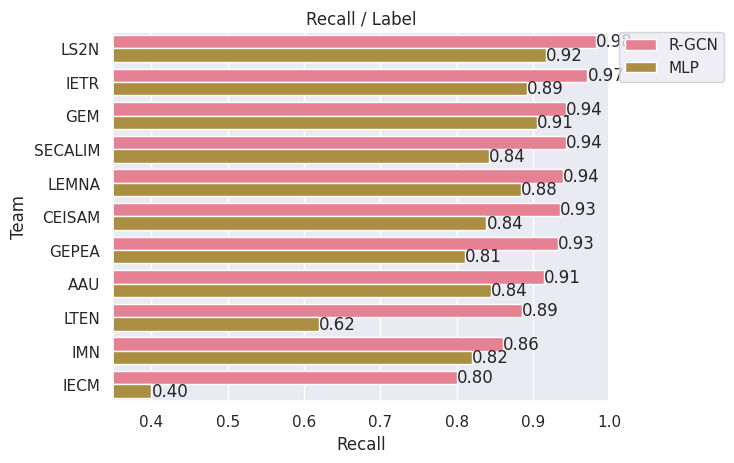

In [98]:
plot_metric(df, "recall", "Model")

<div id="conclusion" >
    <h1 style="font-family:verdana;" > Conclusion </h1>
</div>

In this notebook we explored Relational **Graph Convolutional Networks (R-GCNs)** applied for multi-label text classification and we noticed how engineering two <br/> relations based on the artciles-metadat combined with **R-GCN** led to **7~8%** performance (Accuracy & F1 Score) increase.

<h1 style="font-family:verdana;" > Thank You :) </h1>